# Use a Simple Device Noise Model

## Introduction

This tutorial shows how to use the Qiskit Aer™ `noise.device` module to automatically generate a noise model for an IBM Q™ hardware device, and use this model to do noisy simulation of `QuantumCircuits` to study the effects of errors which occur on real devices.

Note that these automatic models are only a highly simplified approximation of the real errors that occur on actual devices. The study of quantum errors on real devices is an active area of research and we discuss the Qiskit Aer tools for configuring more detailed noise models in another notebook.

## Device noise module

The Qiskit Aer device noise module contains two functions to automatically generate a simplified noise model for a real device. This model is generated using the calibration information reported in the `BackendProperties` of a device.

In [1]:
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

### IBM Q Provider

We will use a real hardware device in the `IBMQ` provider as an example. First we must load our account credentials, and then select a backend from the provider.

In [14]:
IBMQ.load_accounts()
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

We will use the `ibmq_14_melbourne` device for this tutorial. We may get the properties of the backend using the `properties` method, the information in the returned `BackendProperties` object will be used to automatically generate a noise model for the device that can be used by the Qiskit Aer `QasmSimulator`. We will also want to get the `coupling_map` for the device from its `configuration` to use when compiling circuits for simulation to most closely mimic the gates that will be executed on a real device

In [15]:
device = IBMQ.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map

### Test circuit for device and simulation comparison

Now we construct a test circuit to compare the output of the real device with the noisy output simulated on the Qiskit Aer `QasmSimulator`. We will prepare a 3-qubit GHZ state $\frac{1}{2}(|0,0,0\rangle + |1,1,1\rangle)$ on qubits 0, 1 and 2. Before running with noise or on the device we show the ideal expected output with no noise.

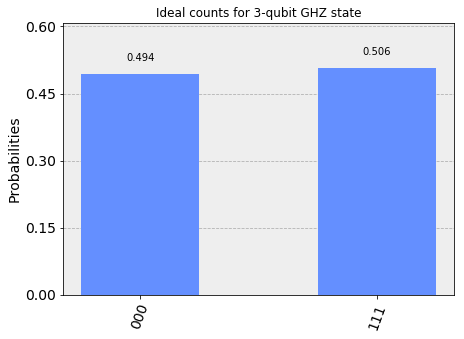

In [10]:
# Construct quantum circuit
qr = QuantumRegister(3, 'qr')
cr = ClassicalRegister(3, 'cr')
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.measure(qr, cr)

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(circ, simulator).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

## Generating a device noise model

Noise models in Qiskit Aer are presented using the `NoiseModel` object from the `aer.noise` module. The function we will use is the `basic_device_noise_model` function from `aer.noise.device` module which will return a basic approximate `NoiseModel` object configured from a device `BackendProperties`.

### Basic device noise model

The `basic_device_noise_model` constructs an approximate noise model consisting of:

* **Single-qubit gate errors** consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.
* **Two-qubit gate errors** consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.
* **Single-qubit readout errors** on the classical bit value obtained from measurements on individual qubits

For the gate errors the error parameter of the thermal relaxation errors is derived using the `thermal_relaxation_error` function from `aer.noise.errors` module, along with the individual qubit $T_1$ and $T_2$ parameters, and the `gate_time` parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxaxtion is equal to the `gate_error` value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit `readout_errors`.

Let us construct the device noise model.

**Note:** *Since the devices don't currently provide the gate times for gates we will manually provide them for the gates we are interested in using the optional `gate_times` argument for `basic_device_noise_model`.*

In [5]:
# List of gate times for ibmq_14_melbourne device
# Note that the None parameter for u1, u2, u3 is because gate
# times are the same for all qubits
gate_times = [
    ('u1', None, 0), ('u2', None, 100), ('u3', None, 200),
    ('cx', [1, 0], 678), ('cx', [1, 2], 547), ('cx', [2, 3], 721),
    ('cx', [4, 3], 733), ('cx', [4, 10], 721), ('cx', [5, 4], 800),
    ('cx', [5, 6], 800), ('cx', [5, 9], 895), ('cx', [6, 8], 895),
    ('cx', [7, 8], 640), ('cx', [9, 8], 895), ('cx', [9, 10], 800),
    ('cx', [11, 10], 721), ('cx', [11, 3], 634), ('cx', [12, 2], 773),
    ('cx', [13, 1], 2286), ('cx', [13, 12], 1504), ('cx', [], 800)
]

# Construct the noise model from backend properties
# and custom gate times
noise_model = noise.device.basic_device_noise_model(properties, gate_times=gate_times)
print(noise_model)

NoiseModel:
  Instructions with noise: ['u2', 'measure', 'u3', 'cx']
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u2', [5]), ('u2', [6]), ('u2', [7]), ('u2', [8]), ('u2', [9]), ('u2', [10]), ('u2', [11]), ('u2', [12]), ('u2', [13]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('u3', [5]), ('u3', [6]), ('u3', [7]), ('u3', [8]), ('u3', [9]), ('u3', [10]), ('u3', [11]), ('u3', [12]), ('u3', [13]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 3]), ('cx', [4, 3]), ('cx', [4, 10]), ('cx', [5, 4]), ('cx', [5, 6]), ('cx', [5, 9]), ('cx', [6, 8]), ('cx', [7, 8]), ('cx', [9, 8]), ('cx', [9, 10]), ('cx', [11, 3]), ('cx', [11, 10]), ('cx', [11, 12]), ('cx', [12, 2]), ('cx', [13, 1]), ('cx', [13, 12]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6]), ('measure', [7]), ('measure', [8]), ('measure', [9]), ('measure', [10]), ('measure', [11]), ('measure', [12]

## Simulating a quantum circuit with noise

To use this noise model we must make use of several keyword arguments in the `execute` function. These are:

* `noise_model`: This passes the noise model to the `QasmSimulator.run` method for noisy simulation.
* `basis_gates`: A noise model is defined with respect to specific gates, we must pass these basis gates to the Qiskit compiler so that it compiles the circuit to the correct gates for the noise model. The basis gates of a noise model may be obtained from the `NoiseModel.basis_gates` property.
* `coupling_map`: We also must make sure we provide the `coupling_map` for the real device so that the compiler will produce a Qobj for the simulator that will match the compiled experiment that can be executed on the real device.

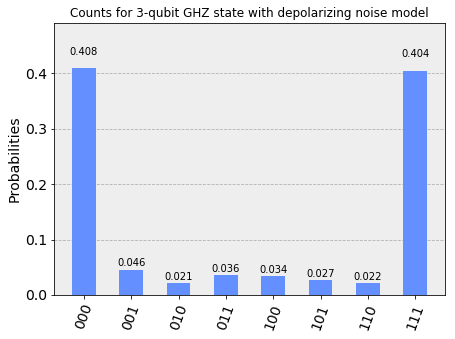

In [6]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute noisy simulation and get counts
result_noise = execute(circ, simulator, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circ)
plot_histogram(counts_noise, title="Counts for 3-qubit GHZ state with depolarizing noise model")

## Comparison to the real device

Now we will execute the circuit on the real device to see the effect of the actual noise processes on the output counts. Note that this execution may take some time to return the results.

In [ ]:
# Submit job to real device and wait for results
job_device = execute(circ, device)
job_monitor(job_device)

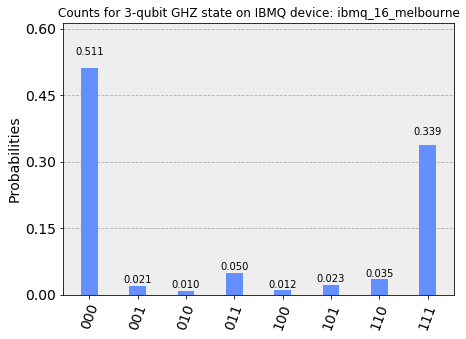

In [8]:
# Get results from completed execution
result_device = job_device.result()
counts_device = result_device.get_counts(0)
plot_histogram(counts_device, title='Counts for 3-qubit GHZ state on IBMQ device: {}'.format(device.name()))

You might notice that the counts returned in the above histogram don't look exactly like our simulation. This is because the real errors that happen on a device can be very complicated, and characterizing them to create acurate models is an active area of quantum computing research. The *basic device noise model* we used for our simulation is a simplified error model that only takes into account *local* errors occuring on the qubits participating in each individual gate, and treats the erors as a relaxation process combined with an error operation which acts to randomize the state of the qubit with some probability *p* (the depolarizing probability). While this model is an approximation, due to its simplicity it is a useful starting point for studying the effects of noise on quantum computations.